# Two class classifcation [CNN]

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import sklearn.preprocessing as preprocessing
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
# import os
# path = '/media/rishabh/Windows/FDrive/MLHackathon/CNN/Training1/1'
# files = os.listdir(path)
# i = 0

# for file in files:
#     os.rename(os.path.join(path, file), os.path.join(path, str(i)+'.jpg'))
#     i = i+1

In [3]:
# files
# path='/home/rishabh/Downloads/MLHackathon/CNN/datasetnew/negs/'
# pathnew='/home/rishabh/Downloads/MLHackathon/CNN/datasetnew/negsold/'
# j=0
# for i in files:
#     img=cv2.imread(path+i)
#     cv2.imwrite(pathnew+str(j)+'.jpg',img)
#     j+=1

In [4]:
def load_data(data_dir):
    print(data_dir)
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".jpg")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels


# Load training and testing datasets.
ROOT_PATH = "/media/rishabh/Windows/FDrive/MLHackathon/CNN/"
train_data_dir = os.path.join(ROOT_PATH, "Training1")
test_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Testing")

images, labels = load_data(train_data_dir)

/media/rishabh/Windows/FDrive/MLHackathon/CNN/Training1


In [5]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

#display_label_images(images, 0)

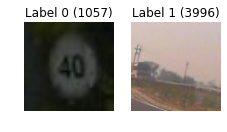

In [6]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

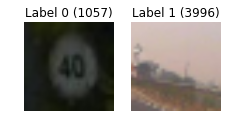

In [7]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32))
                for image in images]
display_images_and_labels(images32, labels)

In [8]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.000440410539216, max: 0.313828890931
shape: (32, 32, 3), min: 0.00116804534314, max: 0.40656786152
shape: (32, 32, 3), min: 0.188265931373, max: 0.740720741422
shape: (32, 32, 3), min: 0.334635416667, max: 0.818504901961
shape: (32, 32, 3), min: 0.258731617647, max: 0.997223498775


In [9]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

('labels: ', (5053,), '\nimages: ', (5053, 32, 32, 3))


In [10]:
def normalize(x):
    return x/255.0

def one_hot_encode(x):
    lb = preprocessing.LabelBinarizer()
    lb.fit(np.array([0,1]))
    return lb.transform(x)


In [11]:
a = one_hot_encode(labels_a)
images_a = normalize(images_a)

In [12]:
b =  np.copy(a)
i = 0
for x in np.nditer(a):
    if x== 0:
        b[i] = 1
        i += 1
    else:
        b[i] = 0
        i += 1
        

In [13]:
#print(a)
#print(b)

In [14]:
labels_a = np.column_stack((b,a))
#print(labels_a)

In [15]:
#images_a

In [16]:
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# import helper
# import numpy as np

# # Explore the dataset
# batch_id = 1
# sample_id = 5
# helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [17]:
def neural_net_image_input(image_shape):
    return tf.placeholder(tf.float32,[None,image_shape[0],image_shape[1],image_shape[2]],name='x')


def neural_net_label_input(n_classes):
    return tf.placeholder(tf.float32,[None,n_classes],name='y')


def neural_net_keep_prob_input():
    return tf.placeholder(tf.float32,name='keep_prob')


def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides,keep_prob):
    s = x_tensor.get_shape().as_list()   
    filter_size_height = s[1] - conv_strides[0]*(conv_ksize[0]-1) +2
    filter_size_width = s[2] - conv_strides[1]*(conv_ksize[1]-1) +2
    W = tf.Variable(tf.truncated_normal([filter_size_height, filter_size_width, s[3], conv_num_outputs]))
    b = tf.Variable(tf.zeros(conv_num_outputs))
    x = tf.nn.conv2d(x_tensor, W, strides=[1,conv_strides[0],conv_strides[1],1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x,ksize=[1,pool_ksize[0],pool_ksize[1],1],strides=[1,pool_strides[0],pool_strides[1],1],padding='SAME')
    #x = tf.nn.dropout(x,keep_prob)
    return x


def flatten(x_tensor):
    shape = x_tensor.get_shape().as_list()       
    dim = np.prod(shape[1:])
    return tf.reshape(x_tensor, [-1, dim])       

def fully_conn(x_tensor, num_outputs):
    shape = x_tensor.get_shape().as_list()
    weights=tf.Variable(tf.truncated_normal([shape[1],num_outputs]))
    biases = tf.Variable(tf.truncated_normal([num_outputs]))
    layer_1 = tf.add(tf.matmul(x_tensor, weights),biases)
    return tf.nn.relu(layer_1)


def output(x_tensor, num_outputs):
    shape = x_tensor.get_shape().as_list()
    weights=tf.Variable(tf.truncated_normal([shape[1],num_outputs]))
    biases = tf.Variable(tf.truncated_normal([num_outputs]))
    return tf.add(tf.matmul(x_tensor, weights),biases)


In [18]:
def conv_net(x, keep_prob):
    
    #conv_1 = conv2d_maxpool(x, 6 , [28,28] ,[1,1], [14,14], [1,1],keep_prob)
    #conv_2 = conv2d_maxpool(conv_1, 15 , [10,10], [1,1], [5,5], [1,1],keep_prob)
    conv_1 = conv2d_maxpool(x, 28 , [3,3] ,[1,1], [3,3], [3,3],keep_prob)
    conv_2 = conv2d_maxpool(conv_1, 16 , [3,3], [1,1], [3,3], [3,3],keep_prob)
    
    x_flat = flatten(conv_2)
    
    fc1 = fully_conn(x_flat, 15)
    fc2 = fully_conn(fc1, 7)
    
    logits = output(fc2,2)
    
    return logits



# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(2)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
prediction = tf.argmax(logits,1,name='prediction')
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

#tests.test_conv_net(conv_net)

In [19]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, feed_dict={x: feature_batch,y: label_batch,keep_prob:keep_probability })
    
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = session.run(cost, feed_dict={x: feature_batch,
                y: label_batch,
                keep_prob: 1.})
    valid_acc = session.run(accuracy, feed_dict={x: feature_batch,
                y:label_batch,
                keep_prob: 1.})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss,valid_acc))

In [20]:
epochs = 700
batch_size = 20
keep_probability = .7

In [21]:
arr = np.arange(5053)
np.random.shuffle(arr)
print arr
images_temp = images_a.copy()
labels_temp = labels_a.copy()
i = 0
for i in range(5053):
    images_a[i] = images_temp[arr[i]]
    labels_a[i] = labels_temp[arr[i]]

[ 643  186 4544 ...,  393 1966 3448]


In [22]:
save_model_path = '/media/rishabh/Windows/FDrive/MLHackathon/CNN/'
print('Checking the Training on a Single Batch')

session_config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)
session_config.gpu_options.per_process_gpu_memory_fraction = 0.8
session_config.gpu_options.allow_growth = True

with tf.Session(config=session_config) as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        for i in range(0, 5053, 2600):
            batchimages = images_a[i:i+2600]
            batchlables = labels_a[i:i+2600]
            train_neural_network(sess, optimizer, keep_probability, batchimages, batchlables)
            print('Epoch {:>2}, Traffic Sign Detection batch '.format(epoch + 1))
            print_stats(sess, images_a, labels_a, cost, accuracy)
#         train_neural_network(sess, optimizer, keep_probability, images_a, labels_a)
#         print('Epoch {:>2}, Traffic Sign Detection  '.format(epoch + 1))
#         print_stats(sess, images_a, labels_a, cost, accuracy)
    
     # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Checking the Training on a Single Batch
Epoch  1, Traffic Sign Detection batch 
Loss:    44.2746 Validation Accuracy: 0.244211
Epoch  1, Traffic Sign Detection batch 
Loss:    15.2673 Validation Accuracy: 0.421928
Epoch  2, Traffic Sign Detection batch 
Loss:    12.7881 Validation Accuracy: 0.756382
Epoch  2, Traffic Sign Detection batch 
Loss:    16.8596 Validation Accuracy: 0.786266
Epoch  3, Traffic Sign Detection batch 
Loss:    18.8660 Validation Accuracy: 0.788047
Epoch  3, Traffic Sign Detection batch 
Loss:    19.0750 Validation Accuracy: 0.788245
Epoch  4, Traffic Sign Detection batch 
Loss:    18.2537 Validation Accuracy: 0.788245
Epoch  4, Traffic Sign Detection batch 
Loss:    16.5848 Validation Accuracy: 0.788443
Epoch  5, Traffic Sign Detection batch 
Loss:    14.3621 Validation Accuracy: 0.787651
Epoch  5, Traffic Sign Detection batch 
Loss:    11.6995 Validation Accuracy: 0.788245
Epoch  6, Traffic Sign Detection batch 
Loss:     8.7596 Validation Accuracy: 0.781714
Epo

In [23]:
save_model_path = '/media/rishabh/Windows/FDrive/MLHackathon/CNN/'

In [24]:
def load_test_data(data_dir):
    print(data_dir)
    images = []
    for d in os.listdir(data_dir):
        images.append(skimage.data.imread(data_dir+d))
            
    return images


In [25]:
sample_images = load_test_data("/media/rishabh/Windows/FDrive/MLHackathon/CNN/datasetnew/pos/")
print(sample_images)

/media/rishabh/Windows/FDrive/MLHackathon/CNN/datasetnew/pos/
[array([[[224, 149, 156],
        [218, 138, 147],
        [224, 136, 148],
        ..., 
        [201, 196, 190],
        [200, 196, 185],
        [199, 196, 181]],

       [[227, 137, 149],
        [225, 131, 145],
        [237, 136, 152],
        ..., 
        [204, 200, 191],
        [205, 202, 187],
        [206, 203, 186]],

       [[233, 128, 145],
        [232, 125, 143],
        [239, 128, 147],
        ..., 
        [195, 193, 180],
        [187, 186, 168],
        [194, 193, 173]],

       ..., 
       [[196, 119, 135],
        [194, 126, 141],
        [190, 136, 149],
        ..., 
        [177, 189, 167],
        [118, 132, 109],
        [ 86, 100,  77]],

       [[204, 106, 129],
        [196, 109, 128],
        [188, 114, 131],
        ..., 
        [164, 167, 150],
        [109, 112,  95],
        [100, 103,  86]],

       [[209, 103, 126],
        [205, 107, 130],
        [194, 109, 128],
        ..., 
     

In [26]:
sample_images = np.array(sample_images)
sample_images32 = [skimage.transform.resize(image, (32, 32))
                for image in sample_images]
sample_images32 = np.array(sample_images32)
sample_images32 = normalize(sample_images32)
print(sample_images32.shape)


(605, 32, 32, 3)


In [27]:
b = np.array([0]*605)
a = np.array([1]*605)
labels_true = np.column_stack((a,b))
print(labels_true)

[[1 0]
 [1 0]
 [1 0]
 ..., 
 [1 0]
 [1 0]
 [1 0]]


In [28]:
def test_model():
    """
    Test the saved model against the test dataset
    """

    #test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        #print(tf.all_variables())
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        loaded_prediction = loaded_graph.get_tensor_by_name('prediction:0')
        accuracy = sess.run([loaded_acc], feed_dict={loaded_x: sample_images32,loaded_y:labels_true, loaded_keep_prob: 1.})
    return accuracy
    

predictions = test_model()

In [29]:
print(predictions)

[0.99008268]
